# Exploratory Data Analysis


## Imports and Data Loading

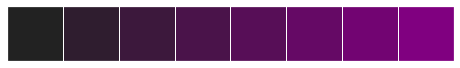

In [215]:
import os
import sys
import random
import squarify
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly
import numpy as np
sources_path = './../sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
import utils
import powerlaw
    
data_dir = './../data'
plots_dir = './plots/'
progbar = utils.ProgressBar(elapsed_time=True)

palette = "purple"
channels = ["email", "mobile", "social", "web"]
sns_palette = sns.dark_palette(palette, n_colors=8)
sns.palplot(sns_palette)
sns.set_palette(sns_palette)
sns.set(font_scale=1.2)

In [3]:
profile = pd.read_json(os.path.join(data_dir, 'profile.json'), lines=True)
portfolio = pd.read_json(os.path.join(data_dir, 'portfolio.json'), lines=True)
transcript = pd.read_json(os.path.join(data_dir, 'transcript.json'), lines=True)

## 1. Processing Profile

The `profile` file contains demographic information about customers, as well as their identification and subscription date.

In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


## 1.1 ID

Changing column name

In [120]:
profile.rename({"id": "person"}, axis=1, inplace=True)
profile.head()

,age,became_member_on,gender,person,income,days_since_subscription
0,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,999
1,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1066
2,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,714
3,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,790
4,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,880


### 1.2 Age

The `age` attribute have a null value of 118. Considering that an age attribute can be roughly modeled as having a normal distribution, we will replace these null values by the mean of the existing values.

In [6]:
profile['age'] = profile['age'].apply(lambda x: np.nan if x == float(118) else float(x))
profile['age'].fillna((profile['age'].mean()), inplace=True)
profile.head()

,age,became_member_on,gender,id,income
0,54.393524,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.000000,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,54.393524,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.000000,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,54.393524,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


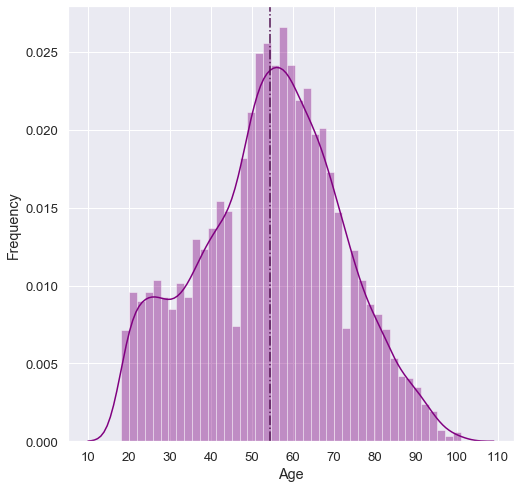

In [184]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(profile.dropna()['age'], ax=ax, color=palette)
ax.axvline(profile.dropna()['age'].mean(), color=sns_palette.as_hex()[3], linestyle='-.')
ax.set_xticks(np.arange(10, 111, 10))
ax.grid(True)
ax.set_xlabel('Age'), ax.set_ylabel('Frequency')
fig.savefig(os.path.join(plots_dir, "age_distribution.jpeg"), bbox_inches="tight")

The mean age of customers is 54 years old, which is quite high. For most countries (the United States included - which is where I believe the data was gathered), the average age is 38 years old. 

### 1.3 Gender

The `gender` attribute has 4 original values with the following number of non-null values: 

- `F`: 6129
- `M`: 8484
- `O`: 212
- `null`: 2175

We will replace the `Null` values by `O`.

In [40]:
profile['gender'] = profile['gender'].apply(lambda x: 'O' if x == None else x)

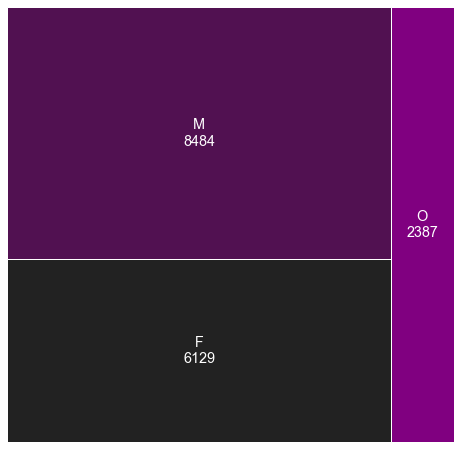

In [87]:
fig, ax = plt.subplots(figsize=(8,8))
df_plot = profile.groupby(['gender']).count()['id'].reset_index(drop=False)
df_plot['gender'] = df_plot['gender'] + '\n' + df_plot['id'].astype(str)
squarify.plot(sizes=df_plot['id'], label=df_plot['gender'], 
              alpha=1, ax=ax, text_kwargs={'color':'white'},
              color=sns_palette.as_hex()[::3])
ax.axis('off')
fig.savefig(os.path.join(plots_dir, "gender_treemap.jpeg"), bbox_inches="tight")

### 1.4 Became Member on

An auxiliary column `days_since_subscription` is created in order to compare customers' time in the company. However, we shall consider as a finishing point for the time delta the current day, since we don't have any information on the time frame the dataset was created. 

In [88]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile["days_since_subscription"] = (pd.Timestamp.today()-profile.became_member_on).dt.days

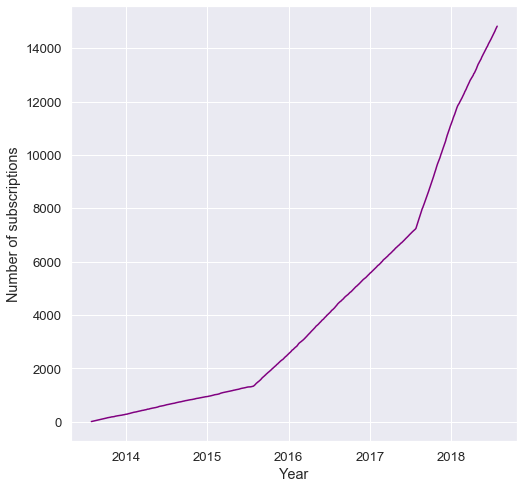

In [119]:
fig, ax = plt.subplots(figsize=(8,8))
df_plot = profile.groupby(['became_member_on']).count()['person'].reset_index(drop=False)
df_plot['id'] = df_plot['person'].cumsum()
sns.lineplot(data=df_plot, x='became_member_on', y='id', ax=ax, color=palette)
ax.grid(True)
ax.set_ylabel('Number of subscriptions'), ax.set_xlabel('Year')
fig.savefig(os.path.join(plots_dir, "subscription_evolution.jpeg"), bbox_inches="tight")

Considering this dataset, Starbucks had a great increase in subscriptions to the reward mobile app between 2017 and 2019.

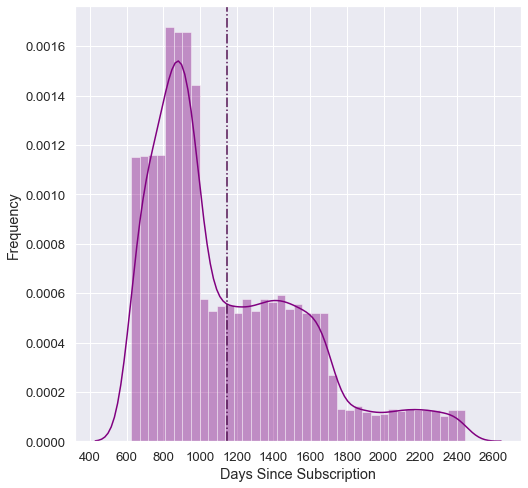

In [192]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(profile.dropna()['days_since_subscription'], 
             ax=ax, color=palette)
ax.axvline(profile.dropna()['days_since_subscription'].mean(), color=sns_palette.as_hex()[3], linestyle='-.')
ax.set_xticks(np.arange(400, 2601, 200))
ax.grid(True)
ax.set_xlabel('Days Since Subscription'), ax.set_ylabel('Frequency')
fig.savefig(os.path.join(plots_dir, "days_since_subscription_distribution.jpeg"), bbox_inches="tight")

### 1.5 Income

Usually an `income` variable follows a long-tail distribution. Although this is not the case, we shall not fill the missing value with any average. So, we drop rows with missing income. 

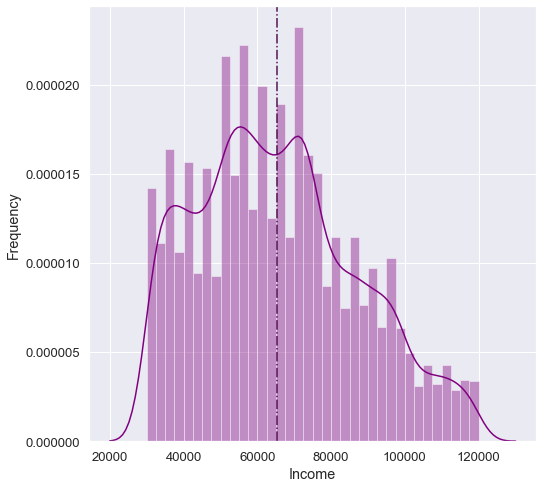

In [193]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(profile.dropna()['income'], ax=ax, 
             color=palette)
ax.axvline(profile.dropna()['income'].mean(), color=sns_palette.as_hex()[3], linestyle='-.')
ax.grid(True)
ax.set_xlabel("Income"), ax.set_ylabel("Frequency")
fig.savefig(os.path.join(plots_dir, "income_distribution.jpeg"), bbox_inches="tight")

In [115]:
profile = profile[profile['income'].notna()].reset_index(drop=True)

## 2. Processing portfolio

The `portfolio` file contains information about the offers to be made.

In [123]:
portfolio.tail()

,channels,difficulty,duration,id,offer_type,reward
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### 2.1 ID

Changing column name

In [124]:
portfolio.rename({'id': 'offer_id'}, axis=1, inplace=True)

### 2.1 Channels

Creating separated columns for each channel

In [125]:
for channel in ['email', 'mobile', 'social', 'web']:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
    
portfolio.drop(['channels'], axis=1, inplace=True)

### 2.2 Offer Type

Creating separated columns for each offer type

In [126]:
for offer in ['bogo', 'informational', 'discount']:
    portfolio[offer] = portfolio['offer_type'].apply(lambda x: 1 if offer in x else 0)
portfolio.drop(['offer_type'], axis=1, inplace=True)

### 2.3 Duration

Converting duration from days to hours

In [127]:
portfolio['duration'] = portfolio['duration']*24

### 2.4 Reward

Casting reward

In [128]:
portfolio['offered_reward'] = portfolio['reward'].astype(int)
portfolio.drop(['reward'], axis=1, inplace=True)

In [129]:
portfolio.tail()

,difficulty,duration,offer_id,email,mobile,social,web,bogo,informational,discount,offered_reward
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1,3
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1,2
7,0,72,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,1,0,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,5
9,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,0,1,2


## 3. Processing Transcript

Finally, the `transcript` file contains log information about offers and their possible consumption.

In [133]:
def get_offer_id(json_string):
    """ Extracts offer id from transcript's value column (when available)
        Attr: 
            json_string: value column from transcript dataframe
        Return: offer id
    """
    json_string = json_string.replace("'", '"').replace('offer_id', 'offer id')    
    if 'offer id' not in json_string:        
        return None
    
    return json.loads(json_string)['offer id']

print ("Input: ", transcript['value'].astype(str)[306509])
print ("Output: ", get_offer_id(transcript['value'].astype(str)[306509]))

Input:  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}
Output:  fafdcd668e3743c1bb461111dcafc2a4


In [134]:
def get_reward(json_string):
    """ Extracts reward from transcript's value column (when available)
        Attr: 
            json_string: value column from transcript dataframe
        Return: reward value
    """
    json_string = json_string.replace("'", '"')
    if "reward" not in json_string:        
        return None
    
    return json.loads(json_string)['reward']

print ("Input: ", transcript['value'].astype(str)[306509])
print ("Output: ", get_reward(transcript['value'].astype(str)[306509]))

Input:  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}
Output:  2


In [135]:
def get_amount(json_string):
    """ Extracts amount from transcript's value column (when available)
        Attr: 
            json_string: value column from transcript dataframe
        Return: amount value
    """
    json_string = json_string.replace("'", '"')
    if "amount" not in json_string:        
        return None
    
    return json.loads(json_string)['amount']

print ("Input: ", transcript['value'].astype(str)[306515])
print ("Output: ", get_amount(transcript['value'].astype(str)[306515]))

Input:  {'amount': 2.6}
Output:  2.6


In [136]:
transcript['offer_id'] = transcript['value'].astype(str).apply(get_offer_id)
transcript['received_reward'] = transcript['value'].astype(str).apply(get_reward)
transcript['amount'] = transcript['value'].astype(str).apply(get_amount)

In [137]:
transcript.tail()

,event,person,time,value,offer_id,received_reward,amount
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999},None,NaN,1.59
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53},None,NaN,9.53
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61},None,NaN,3.61
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002},None,NaN,3.53
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05},None,NaN,4.05


## 4. Building Offers Log Dataframe

The `df_offers` dataframe shall contain informations for an offer on a single row, instead of making it in multiple rows as in `transcript`. 

In [139]:
log = pd.merge(transcript, portfolio, how='left', on='offer_id').sort_values(by=['person', 'time'])

Wall time: 949 ms


The following cell may take a little while to run

In [140]:
%%time
first_offer = True
n_people = log["person"].nunique()

for index_person, person in enumerate(log["person"].unique()):
    progbar.update_progress(index_person/n_people)
    
    df_person = log[log['person'] == person].reset_index(drop=True)
    index_offer_received = df_person[df_person["event"] == "offer received"].index
    
    for index in index_offer_received:
        time = df_person.iloc[index]["time"]
        duration = df_person.iloc[index]["duration"]
        offer_id = df_person.iloc[index]["offer_id"]

        df_timeframe = df_person.query("(time >= @time and time <= @time+@duration)")
        df_timeframe = df_timeframe[df_timeframe["offer_id"].isin([offer_id, None])]
        future_purchase = 0
        
        if "offer viewed" in df_timeframe["event"].unique():    
            offer_viewed = 1
            time_to_viewed = list(df_timeframe.query("event == 'offer viewed'")["time"])[0]-time

        if "offer completed" in df_timeframe["event"].unique():    
            offer_completed = 1    
            time_completed = list(df_timeframe.query("event == 'offer completed'")["time"])[0]
            time_to_completed = time_completed-time
            amount = list(df_timeframe.query("event == 'transaction' and time == @time_completed")["amount"])[0]
            transaction_without_completion = 0
            
            if "transaction" in df_timeframe.query("time > @time_completed")["event"].unique():
                future_purchase = 1            
        else: 
            offer_completed = 0
            amount = 0
            time_to_completed = None
            if "transaction" in df_timeframe["event"].unique(): 
                transaction_without_completion = 1    

        offer = {"person": person, "time": time, "duration": duration, "offer_id": offer_id, 
                 "offer_viewed": offer_viewed, "time_to_viewed": time_to_viewed, 
                 "offer_completed": offer_completed, "time_to_completed": time_to_completed, 
                 "amount": amount, "transaction_without_completion": transaction_without_completion, 
                 "future_purchase": future_purchase
        }

        if first_offer:
            df_offers = pd.DataFrame(columns = offer.keys())
            first_offer = False

        df_offers = df_offers.append(offer, ignore_index=True)

[1:39:27][##########] 99.99% Wall time: 1h 39min 28s


In [ ]:
df_offers["time_from_viewed_to_completed"] = df_offers["time_to_completed"] - df_offers["time_to_viewed"]

In [ ]:
df_offers_bkp = df_offers.copy()

In [297]:
df_offers["offer_viewed"] = df_offers["offer_viewed"].astype(int)
df_offers["offer_completed"] = df_offers["offer_completed"].astype(int)
# df_offers["time_to_completed"] = df_offers["time_to_completed"].astype(int)
df_offers["time_to_viewed"] = df_offers["time_to_viewed"].astype(int)
df_offers["time"] = df_offers["time"].astype(int)
df_offers["amount"] = df_offers["amount"].astype(float)
df_offers["future_purchase"] = df_offers["future_purchase"].astype(int)
df_offers["transaction_without_completion"] = df_offers["transaction_without_completion"].astype(int)

In [142]:
df_offers = pd.merge(df_offers.drop("duration", axis=1), portfolio, on='offer_id', how="left")
df_offers = pd.merge(df_offers, profile, on='person', how="inner")
df_offers.tail()

,person,time,offer_id,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,...,web,bogo,informational,discount,offered_reward,age,became_member_on,gender,income,days_since_subscription
66496,ffff82501cea40309d5fdd7edcca4a07,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,6,1,30,22.88,0,1,...,1,0,0,1,5,45.0,2016-11-25,F,62000.0,1231
66497,ffff82501cea40309d5fdd7edcca4a07,336,2906b810c7d4411798c6938adc9daaa5,1,18,1,48,15.57,0,1,...,1,0,0,1,2,45.0,2016-11-25,F,62000.0,1231
66498,ffff82501cea40309d5fdd7edcca4a07,408,2906b810c7d4411798c6938adc9daaa5,1,6,1,6,17.55,0,1,...,1,0,0,1,2,45.0,2016-11-25,F,62000.0,1231
66499,ffff82501cea40309d5fdd7edcca4a07,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,30,1,0,7.79,0,1,...,1,1,0,0,5,45.0,2016-11-25,F,62000.0,1231
66500,ffff82501cea40309d5fdd7edcca4a07,576,2906b810c7d4411798c6938adc9daaa5,1,6,1,0,14.23,0,1,...,1,0,0,1,2,45.0,2016-11-25,F,62000.0,1231


## 5. Creating Reward Column

The `reward` column is used by the Multi-Armed Bandit algorithm to get how good was an offer considering its product's attributes and the marketing channels. For example, even though a consumer didn't complete an offer, the fact that he viewed it infers that the marketing channel completed one of its purposes: making the user aware of the offer. So, a small reward is given to the offer. 

Furthermore, if the user completed the offer, more reward is given to the strategy and the amount of reward is proportional to how much the user gained from the challenge. 

Ultimately, if the user completed a future offer after the one given, that indicates that he became a regular customer. In this case, even more reward is given to the  strategy.

In [301]:
df_offers["reward"] = df_offers["offer_viewed"] + df_offers["offer_completed"]*df_offers["offered_reward"] + 2*df_offers["future_purchase"]

Saving all processed files

In [144]:
df_offers.to_csv(os.path.join(data_dir, "df_offers.csv"), sep=';', index=None)
profile.to_csv(os.path.join(data_dir, "profile.csv"), sep=';', index=None)
portfolio.to_csv(os.path.join(data_dir, "portfolio.csv"), sep=';', index=None)
transcript.to_csv(os.path.join(data_dir, "transcript.csv"), sep=';', index=None)

## 6. Analyzing Marketing Funnel Performance

### 6.1 Time lapse between sent offer and funnel touchpoints

How much does a user takes to view the offer? And how much does he take to complete it?

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Powerlaw alpha for time_to_viewed: 10.57
Powerlaw alpha for time_from_viewed_to_completed: 7.01


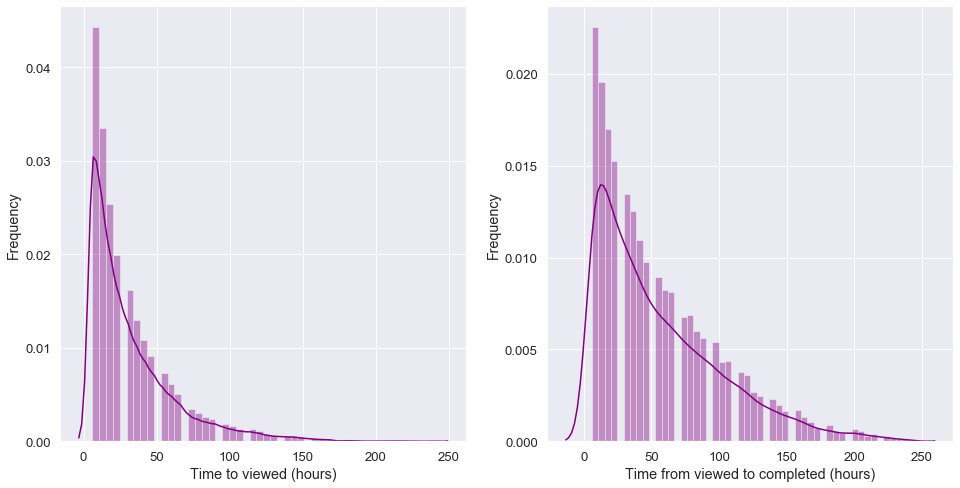

In [345]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,8))
for i, analysis in enumerate(["time_to_viewed", "time_from_viewed_to_completed"]):
    df_plot = df_offers.dropna()
    df_plot = df_plot[df_plot[analysis] > 0]
    
    results = powerlaw.Fit(df_plot[analysis])
    print ("Powerlaw alpha for {}: {:.02f}".format(analysis, results.power_law.alpha))
    
    sns.distplot(df_plot[analysis], ax=axes[i], color=palette)
    axes[i].set_xlabel(analysis.replace('_', ' ').capitalize() + " (hours)")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)
    
fig.savefig(os.path.join(plots_dir, "time_distribution.jpeg"), bbox_inches="tight")

(Text(0.5, 0, 'Mean time (hours) for the offer to be viewed'),
 Text(0, 0.5, 'Channel'))

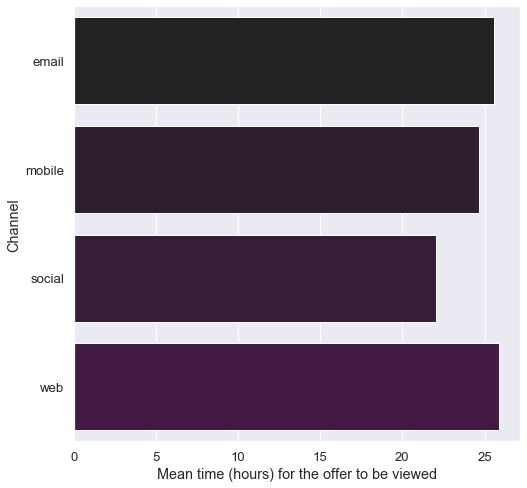

In [335]:
fig, ax = plt.subplots(figsize=(8,8))
channels, avg = ["email", "mobile", "social", "web"], []
for channel in channels:
    avg.append(df_offers[df_offers[channel] == 1]["time_to_viewed"].mean())
df_plot = pd.DataFrame()    
df_plot["channel"] = channels
df_plot["avg"] = avg
sns.barplot(data=df_plot, x="avg", y="channel", palette=sns_palette, ax=ax)
ax.set_xlabel("Mean time (hours) for the offer to be viewed"), ax.set_ylabel("Channel")

In general, the time frame between sending an offer and the user viewing it follows a long-tail distribution. In other words, most of the users view the offer in a short period of time. However, on the mean average, using **social media** and **mobile** as a marketing channel makes this time shorter. 

Additionally, if the customer chooses to complete the challenge, most of them also take less time from viewing and offer and completing it, making this second time frame a long-tail distribution. However, this distribution is not as steep as the first one. 

Recall that a powerlaw distribution has the following form: 

$$p(x) \propto x^{-\alpha}$$

where, the higher $\alpha$, the steeper the distribution. So, by fitting both distributions to a powerlaw, the following coefficients are found: 

- Time to viewed: $alpha = 10.57$
- Time from viewed to completed: $\alpha = 7.01$

### 6.2 Marketing Funnel Flow

Visualizing the flow of customers on the marketing funnel

In [195]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 10,
      line = dict(color = "black", width = 0.1),
      label = ["Offer Sent", "Social", "Web", "Mobile", "Email", "Purchase Completed", "Purchase Without Offer", "Future Purchases"],
      color = palette
    ),
    link = dict(
      source = [0, 0, 0, 0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 6], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [1, 2, 3, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7],        
      value = [df_offers['social'].sum(), 
              df_offers['web'].sum(), 
              df_offers['mobile'].sum(), 
              df_offers['email'].sum(), 
              df_offers.query("social == 1")["offer_completed"].sum(), 
              df_offers.query("web == 1")["offer_completed"].sum(),
              df_offers.query("mobile == 1")["offer_completed"].sum(),
              df_offers.query("email == 1")["offer_completed"].sum(),
              df_offers.query("social == 1")["transaction_without_completion"].sum(),
              df_offers.query("web == 1")["transaction_without_completion"].sum(),
              df_offers.query("mobile == 1")["transaction_without_completion"].sum(),
              df_offers.query("email == 1")["transaction_without_completion"].sum(),
              df_offers.query("offer_completed == 1")["future_purchase"].sum(),
              df_offers.query("transaction_without_completion == 1")["future_purchase"].sum(),]
  ))])

# fig.update_layout(title_text="Marketing Funnel", font_size=10)
fig.update_layout(font_size=12)

In [196]:
plotly.offline.plot(fig, filename = os.path.join(plots_dir, 'marketing_funnel.html'), auto_open=False)

'./plots/marketing_funnel.html'

In [353]:
for channel in channels:
    df_temp = df_offers.query(channel + " == 1")
    performance = df_temp.query("offer_completed == 1").shape[0]/df_temp.shape[0]
    print ("{} channel performance: {:.02f} %".format(channel.title(), 100*performance))

Email channel performance: 48.84 %
Mobile channel performance: 48.64 %
Social channel performance: 52.69 %
Web channel performance: 54.20 %


From the flow above, we can check that social media is the less used marketing channel where offers are sent. The effectivess of each channel, considering the fraction of offers that are completed, is: 

- Email: 48.84 %
- Mobile: 48.64 %
- Social: 52.69 %
- Web: 54.20 %

### 6.3 Top completed offers

What are the most completed offers?

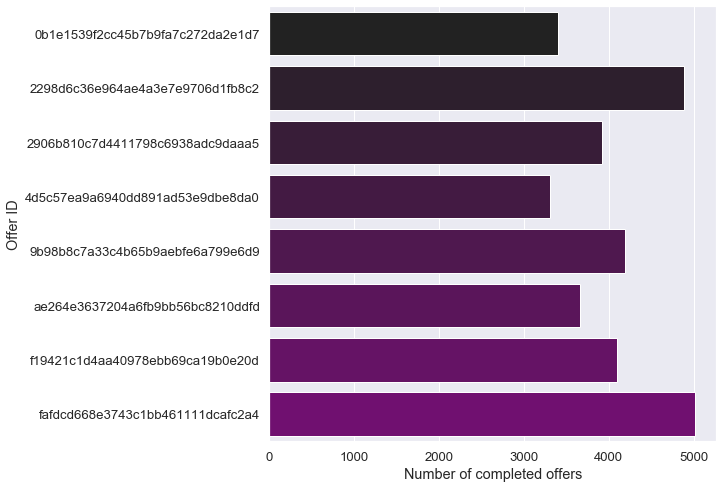

In [233]:
fig, ax = plt.subplots(figsize=(8,8))
df_plot = df_offers[df_offers["offer_completed"] == 1]
sns.countplot(y=df_plot['offer_id'], order=sorted(df_plot["offer_id"].unique()),
              palette=sns_palette)
ax.set_xlabel('Number of completed offers')
ax.set_ylabel('Offer ID')
fig.savefig(os.path.join(plots_dir, "completed_offers_per_id.jpeg"), bbox_inches="tight")

### 6.4 Top future purchase offers

Which offers lead to the more purchases in the future? 

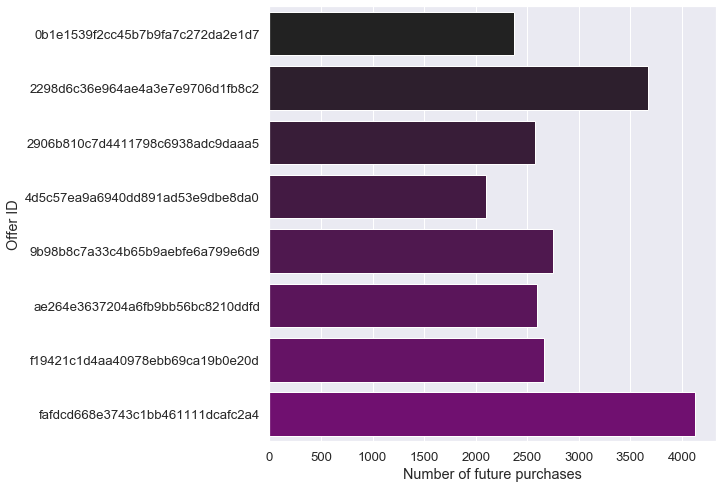

In [236]:
fig, ax = plt.subplots(figsize=(8,8))
df_plot = df_offers[df_offers["future_purchase"] == 1]
sns.countplot(y=df_plot['offer_id'], 
              palette=sns_palette, order=sorted(df_plot["offer_id"].unique()))
ax.set_xlabel('Number of future purchases')
ax.set_ylabel('Offer ID')

fig.savefig(os.path.join(plots_dir, "future_purchases_per_id.jpeg"), bbox_inches="tight")

### 6.4 Channels' Rewards

Which channel has the most reward?

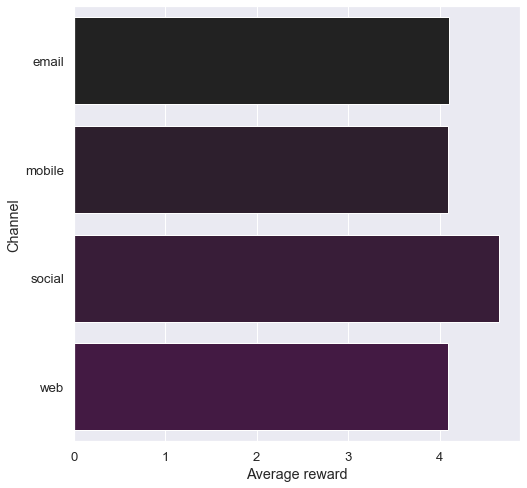

In [269]:
fig, ax = plt.subplots(figsize=(8,8))
channels = ["email", "mobile", "social", "web"]
avg_rewards = []
for channel in channels:
    avg_rewards.append(df_offers[df_offers[channel] == 1]["reward"].mean())
df_plot = pd.DataFrame()    
df_plot["channel"] = channels
df_plot["avg_reward"] = avg_rewards
sns.barplot(data=df_plot, x="avg_reward", y="channel", palette=sns_palette, ax=ax)
ax.set_xlabel("Average reward")
ax.set_ylabel("Channel")

fig.savefig(os.path.join(plots_dir, "average_reward_per_channel.jpeg"), bbox_inches="tight")

### 6.5 Correlation Map

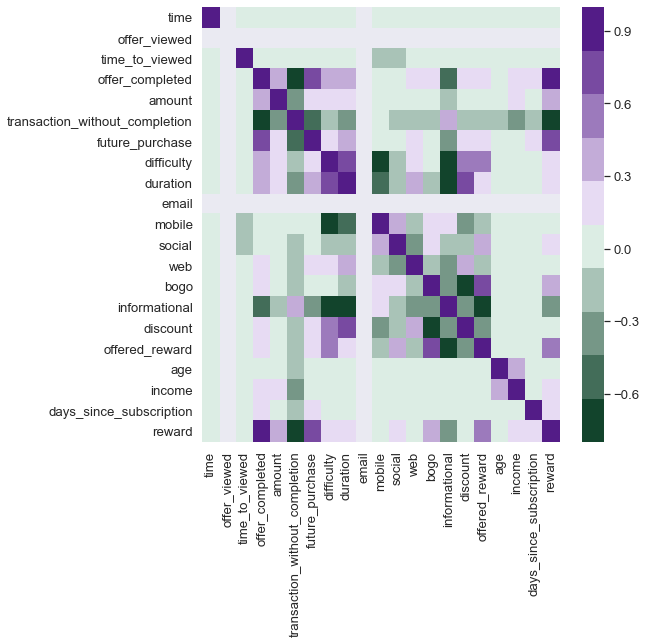

In [359]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_offers.corr(), ax=ax, cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10))
fig.savefig(os.path.join(plots_dir, "offers_heatmap.jpeg"), bbox_inches="tight")

- In general, completed offers have a strong and positive correlation to future purchases, which tells us that a fidelity component is present
- Completed offers, however, have a negative correlation with the `informational` offer type. 
- `transaction_without_completion` and `amount` have negative correlation. This might mean that, when consumers don't use the reward program, they tend to spend a smaller amount.
- `future_purchase` has a slightly positive correlation to `duration`. We may infer that, when an offer has longer duration, it might permit the consumer to finish the challenge and then continue buying in the reward app.
- Although `future_purchase` has a really strong and positive correlation to `reward`, we must remember that the first variable is used to calculate the later.
- The higher the `difficulty`, the longer the duration of the offer. This could be inferred by the `portfolio` data. 
- Difficult challenges tend to not be sent through the mobile channel. 
- `informational` offer types tend to be easier (lower difficulty)
- Older customers tend to earn higher salaries
- Younger people tend to complete more challenges
